# Project - Solar Energy Production Forecasting
## Part 1 - Load data + EDA

Steps:
- Load train and test datasets
- Ensure chronological order (no shuffling)
- Create a 70/30 Train/Validation split **by time**
- Perform minimal sanity checks (shape, missing values, target leakage)

### Import Packages

In [24]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Load Datasets

In [3]:
#loading datasets and basic checks
TRAIN_URL = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
TEST_URL  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

display(train_df.head())
display(test_df.head())

Train shape: (176505, 17)
Test shape : (59376, 17)


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2020-01-04 00:00:00+00:00,0,0.0,0.0,N,4.0,1.23,17.21,1.0,0.0,0.0,2.5,277.0,0,2.0,84.0,5.04
1,2020-01-04 01:00:00+00:00,0,0.0,0.0,N,4.0,0.28,17.39,1.0,0.0,-0.3,1.8,290.0,0,2.0,86.0,5.40
2,2020-01-04 02:00:00+00:00,0,0.0,0.0,N,4.0,-0.89,18.57,0.0,0.0,-0.7,0.9,297.0,0,2.0,89.0,5.76
3,2020-01-04 03:00:00+00:00,0,0.0,0.0,N,4.0,-1.96,19.75,0.0,0.0,-1.1,0.1,300.0,0,2.0,92.0,6.12
4,2020-01-04 04:00:00+00:00,0,0.0,0.0,N,3.0,-2.30,19.93,0.0,0.0,-1.4,-0.2,299.0,0,2.0,92.0,6.12


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2021-08-26 00:00:00+00:00,0,0.004,0.004,N,8.0,17.50,21.32,0.0,0.0,13.1,17.5,345.0,0,7.0,76.0,6.48
1,2021-08-26 01:00:00+00:00,0,0.004,0.004,N,8.0,17.10,19.41,0.0,0.0,13.0,17.1,341.0,0,7.0,77.0,6.12
2,2021-08-26 02:00:00+00:00,0,0.004,0.004,N,6.0,16.50,20.50,0.0,0.0,12.8,16.5,341.0,0,7.0,79.0,5.76
3,2021-08-26 03:00:00+00:00,0,0.004,0.004,N,6.0,15.80,20.58,0.0,0.0,12.6,15.8,342.0,0,7.0,81.0,5.40
4,2021-08-26 04:00:00+00:00,0,0.004,0.004,D,6.0,15.65,22.67,0.0,0.0,12.5,15.2,359.0,0,8.0,84.0,5.04


### Parse dates and check `NaNs`

In [7]:
time_col = 'UTC Time'

train_df[time_col] = pd.to_datetime(train_df[time_col], errors="coerce")
test_df[time_col]  = pd.to_datetime(test_df[time_col], errors="coerce")

train_df = train_df.sort_values(time_col).reset_index(drop=True)
test_df  = test_df.sort_values(time_col).reset_index(drop=True)

In [8]:
#checking for missing values

def missing_report(df, name='df'):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss>0]
    print(f"\nMissingness report — {name}")
    if len(miss) == 0:
        print("No missing values")
        return
    display((miss * 100) * 100).round(2).to_fram('% of missing values')

missing_report(train_df, "train_df")
missing_report(test_df, "test_df")


Missingness report — train_df
No missing values

Missingness report — test_df
No missing values


### Joining both datasets for EDA

In [9]:
#joining both dfs for EDA
df = pd.concat([train_df, test_df], join="inner").sort_values("UTC Time").sort_values("Plant_ID")
df.shape

(235881, 17)

In [10]:
df.describe()

,Plant_ID,Energy_Production,Benchmark,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
count,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,2.358810e+05,235881.000000,235881.000000,235881.000000
mean,7.670859,0.008685,0.008677,6.076560,11.535787,18.994054,10.469979,0.010241,6.796013,12.109901,143.582056,-3.277474e+06,9.581433,72.889347,7.436998
std,4.577249,0.014589,0.014576,1.945064,9.347031,8.756769,17.102289,0.040474,6.631462,8.387371,114.718993,8.383085e+07,4.858372,16.940525,2.438261
min,0.000000,0.000000,0.000000,3.000000,-10.240000,0.000000,0.000000,0.000000,-13.100000,-7.600000,0.000000,-2.147484e+09,1.000000,15.000000,0.160000
25%,4.000000,0.000000,0.000000,4.000000,4.200000,14.000000,1.000000,0.000000,1.800000,5.500000,37.000000,0.000000e+00,7.000000,61.000000,5.760000
50%,8.000000,0.000000,0.000000,6.000000,9.960000,19.090000,4.000000,0.000000,6.200000,10.700000,112.000000,0.000000e+00,8.000000,77.000000,7.200000
75%,12.000000,0.012000,0.012000,8.000000,18.300000,23.260000,9.000000,0.000000,12.100000,18.300000,231.000000,0.000000e+00,15.000000,87.000000,8.640000
max,15.000000,0.097000,0.097000,12.000000,39.840000,73.850000,84.000000,0.650000,22.700000,35.600000,359.000000,4.600000e+01,18.000000,99.000000,27.000000


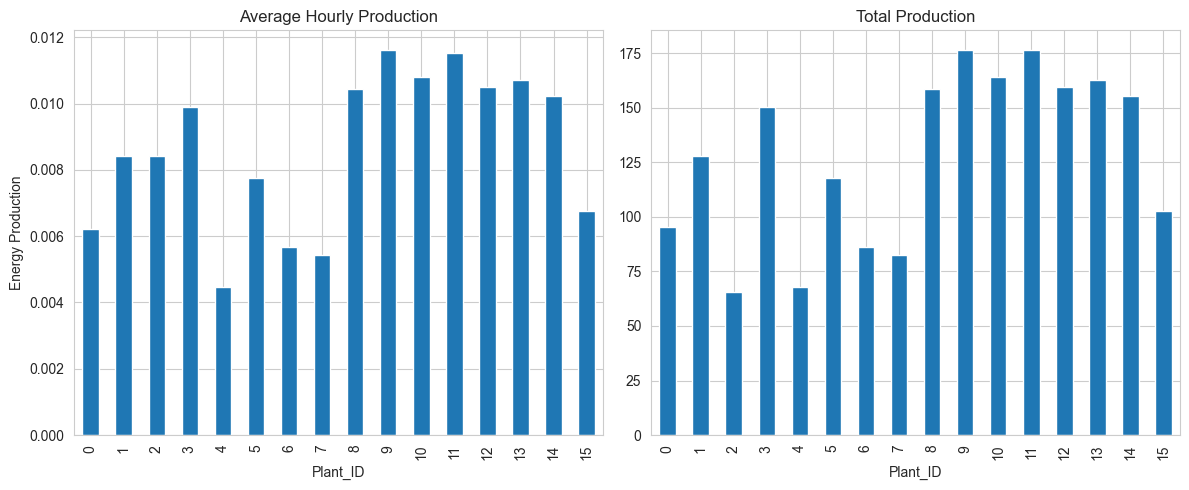

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

df.groupby('Plant_ID')['Energy_Production'].mean().plot(kind='bar', ax=axes[0], title="Average Hourly Production")
axes[0].set_ylabel("Energy Production")

df.groupby('Plant_ID')['Energy_Production'].sum().plot(kind='bar', ax=axes[1], title="Total Production")
plt.tight_layout()
plt.show()

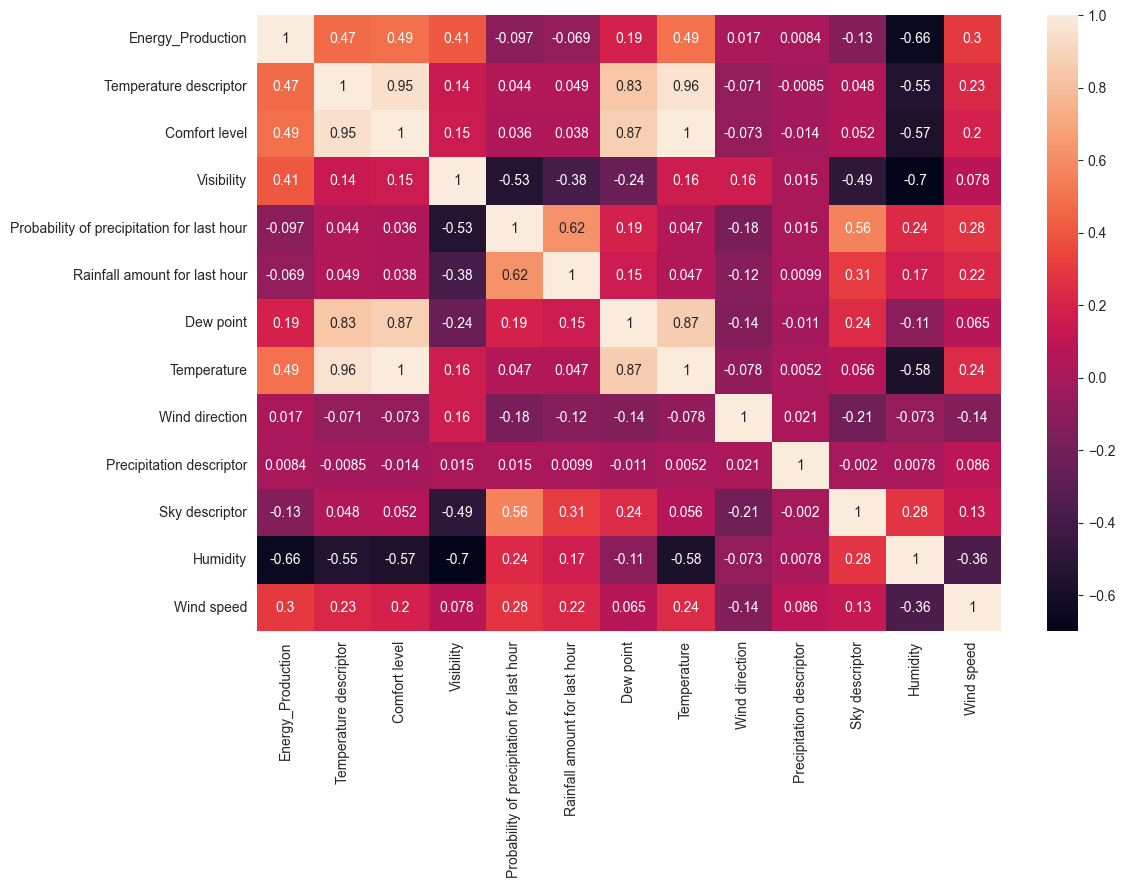

In [12]:
import seaborn as sns

corr = df[['Energy_Production',
       'Temperature descriptor', 'Comfort level', 'Visibility',
       'Probability of precipitation for last hour',
       'Rainfall amount for last hour', 'Dew point', 'Temperature',
       'Wind direction', 'Precipitation descriptor', 'Sky descriptor',
       'Humidity', 'Wind speed']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True)
plt.show()

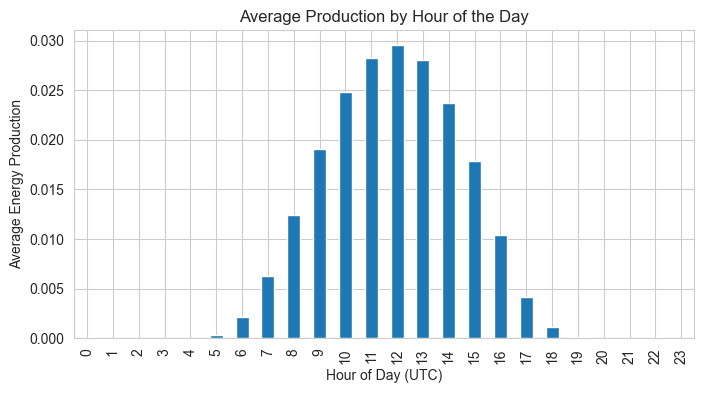

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))

df['UTC Time'] = pd.to_datetime(df['UTC Time'])
df['hour'] = df['UTC Time'].dt.hour

(
    df.groupby('hour')['Energy_Production']
      .mean()
      .plot(
          kind='bar',
          ax=ax,
          title="Average Production by Hour of the Day"
      )
)

ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Average Energy Production")
plt.show()

### Variance by plant

In [15]:
plant_variance = (df.groupby('Plant_ID')['Energy_Production'].agg(
          variance='var',
          std='std',
          mean='mean',
          count='count')
      .sort_values('variance', ascending=False))

display(plant_variance)

,variance,std,mean,count
Plant_ID,,,,
9,0.000338,0.018372,0.011623,15191
11,0.000325,0.018034,0.011523,15311
13,0.000295,0.017163,0.010709,15191
10,0.000292,0.017080,0.010802,15191
8,0.000278,0.016684,0.010434,15191
12,0.000275,0.016571,0.010493,15191
14,0.000264,0.016245,0.010231,15191
3,0.000258,0.016059,0.009881,15191
1,0.000192,0.013864,0.008413,15191


In [18]:
print(df.describe())
print(df.info)

            Plant_ID  Energy_Production      Benchmark  \
count  235881.000000      235881.000000  235881.000000   
mean        7.670859           0.008685       0.008677   
std         4.577249           0.014589       0.014576   
min         0.000000           0.000000       0.000000   
25%         4.000000           0.000000       0.000000   
50%         8.000000           0.000000       0.000000   
75%        12.000000           0.012000       0.012000   
max        15.000000           0.097000       0.097000   

       Temperature descriptor  Comfort level     Visibility  \
count           235881.000000  235881.000000  235881.000000   
mean                 6.076560      11.535787      18.994054   
std                  1.945064       9.347031       8.756769   
min                  3.000000     -10.240000       0.000000   
25%                  4.000000       4.200000      14.000000   
50%                  6.000000       9.960000      19.090000   
75%                  8.000000      1

# Part 2 Feature Engineering

### Cyclical Feature Encoding

Some variables represent cyclical phenomena rather than linear quantities.

- Hour of day (0–23) is cyclical: hour 23 is close to hour 0.
- Wind direction (0–359°) is circular: 359° is close to 0°.

To preserve this structure, we apply sine and cosine transformations.
This allows machine learning models to learn smooth periodic patterns
without artificial discontinuities.

In [19]:

# Cyclical encoding: hour of day
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding: wind direction (degrees)
df['wind_dir_rad'] = np.deg2rad(df['Wind direction'])
df['wind_dir_sin'] = np.sin(df['wind_dir_rad'])
df['wind_dir_cos'] = np.cos(df['wind_dir_rad'])

# Drop intermediate column
df.drop(columns=['wind_dir_rad'], inplace=True)

In [20]:
# Ensure proper ordering
df = df.sort_values(['Plant_ID', 'UTC Time']).reset_index(drop=True)

### Panel-Safe Lag and Rolling Features

The dataset is panel data, with observations indexed by Plant_ID and time. To avoid data leakage:
- All lagged and rolling features are computed **for each plant**
- Rolling statistics only use **past values** via a shift
- The data is sorted by time before feature construction

These features allow the model to capture short-term persistence and
local trends in energy production.


In [21]:
# Lagged energy production (allowed by instructions)
for lag in [1, 3, 6, 12, 24]:
    df[f'Energy_Production_lag_{lag}'] = (
        df.groupby('Plant_ID')['Energy_Production']
          .shift(lag)
    )

In [22]:
# Rolling window features (past-only)
for window in [3, 6, 12, 24]:
    df[f'EP_roll_mean_{window}'] = (
        df.groupby('Plant_ID')['Energy_Production']
          .shift(1)
          .rolling(window)
          .mean()
    )

    df[f'EP_roll_std_{window}'] = (
        df.groupby('Plant_ID')['Energy_Production']
          .shift(1)
          .rolling(window)
          .std()
    )

### PCA on Weather Features

Weather variables exhibit strong multicollinearity.We apply Principal Component Analysis (PCA) to continuous weather features only.

Steps:
- Standardize all features
- Retain components explaining 95% of total variance
- Replace original weather variables with PCA components

This reduces dimensionality while preserving most of the information, and allows us to compare model performance with and without PCA.


In [25]:
weather_features = [
    'Temperature',
    'Comfort level',
    'Visibility',
    'Probability of precipitation for last hour',
    'Rainfall amount for last hour',
    'Dew point',
    'Humidity',
    'Wind speed'
]

X_weather = df[weather_features].copy()

In [26]:
scaler = StandardScaler()
X_weather_scaled = scaler.fit_transform(X_weather)

In [30]:
pca = PCA(n_components=0.95, random_state=13)
X_pca = pca.fit_transform(X_weather_scaled)

print(f"Original features: {X_weather.shape[1]}")
print(f"PCA components   : {X_pca.shape[1]}")

Original features: 8
PCA components   : 5


In [31]:
pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = df.copy()

for i, col in enumerate(pca_cols):
    df_pca[col] = X_pca[:, i]